# Bias vs Variance

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.io as io
%matplotlib inline

## Regularized Linear Regression 

In [2]:
# Load data.
data = io.loadmat(os.path.join('data', 'ex5data1.mat'))
# Training data.
X, y = data['X'], data['y'].flatten()
# Cross-validation data.
Xval, yval = data['Xval'], data['yval'].flatten()
# Test data
Xtest, ytest = data['Xtest'], data['ytest'].flatten()

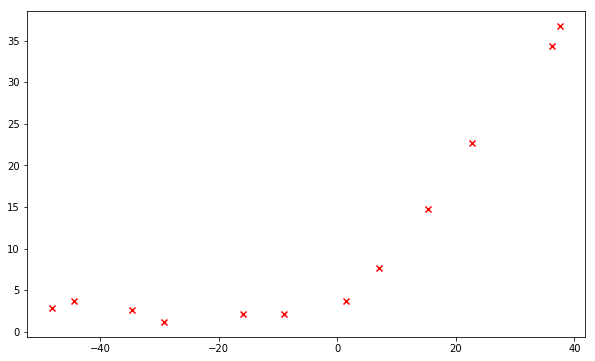

In [3]:
# Visualization.
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(X, y, marker='x', c='r')

In [4]:
def cost_function(theta, x, y, regulator=0):
    m = len(y)
    x_copy = np.insert(x, 0, 1, axis=1)
    hypothesis = np.einsum('j,ij->i', theta, x_copy)
    cost = np.sum(np.square(hypothesis - y)) / 2 / m
    reg_term = (regulator / 2 / m) * np.sum(theta * theta)
    return cost + reg_term

In [5]:
theta = np.array([1, 1])
cost_function(theta, X, y)

303.9515255535976

In [6]:
def gradient(theta, x, y, regulator=0):
    m = len(y)
    x_copy = np.insert(x, 0, 1, axis=1)
    hypothesis = np.einsum('j,ij->i', theta, x_copy)
    grad = np.einsum('i,ij->j', hypothesis - y, x_copy) / m
    reg_term = (regulator / m) * theta
    return grad + reg_term

In [7]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

In [8]:
# Training
def optimize_theta(initial_theta, x, y, regulator=0):
    result = opt.minimize(cost_function, 
                          initial_theta, 
                          args=(x, y, regulator),
                          jac=gradient,
                          method='CG',
                          options={'maxiter':500})
    return result.x

In [9]:
theta = np.zeros(X.shape[1] + 1)
theta = optimize_theta(theta, X, y)

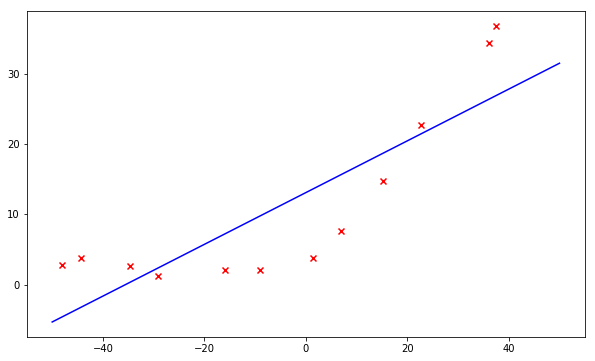

In [10]:
# Prediction
def prediction(theta, x):
    x_copy = np.insert(x, 0, 1, axis=1)
    return np.einsum('j,ij->i', theta, x_copy)

def plot_prediction(theta, x, y):
    x_pred = np.linspace(-50, 50, 30)[:, None]
    y_pred = prediction(theta, x_pred)
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.scatter(x, y, marker='x', c='r')
    ax.plot(x_pred, y_pred, c='b')
    
plot_prediction(theta, X, y)

This shows that linear regression is not a good model for this data.

### Learning Curves

In [11]:
def plot_learning_curves(xtrain, ytrain, xval, yval, regulator=0):
    m, n = xtrain.shape
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    theta = np.zeros(n + 1)
    num_samples = np.arange(m)
    for i in num_samples:
        theta = optimize_theta(theta, xtrain[:i+1, :], ytrain[:i+1], regulator)
        error_train[i] = cost_function(theta, xtrain[:i+1, :], ytrain[:i+1])
        error_val[i] = cost_function(theta, xval, yval)
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.plot(num_samples, error_train, label='Training error')
    ax.plot(num_samples, error_val, label='Cross-Validation error')
    ax.legend()
    ax.set_xlabel('Number of trainig samples')
    ax.set_ylabel('Error')

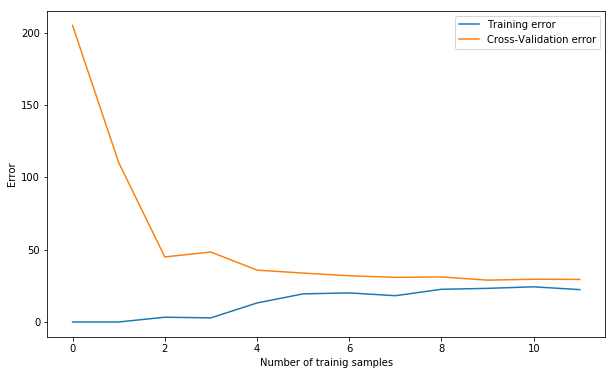

In [12]:
plot_learning_curves(X, y, Xval, yval)

### Polynomial Features

In [13]:
def poly_features(x, p):
    """
    Maps the m x 1 data to a m x p feature matrix, 
    where the i-th column has the i-th powers of 
    the data.
    """
    if x.ndim == 1:
        x = x[:, None]
    powers = np.arange(1, p + 1)
    return np.power(x, powers)

In [21]:
def feature_normalize(x):
    """
    Here x is the m x n feature matrix. Normalizing
    the features would involve subtracting their 
    respective means from the dataset and dividing by
    thei respective standard deviations.
    """
    x_copy = x.copy()
    mu = np.mean(x_copy, axis=0) # mean of each column
    sigma = np.std(x_copy, axis=0) # standard deviation of each column
    x_copy = (x_copy - mu) / sigma
    return x_copy, mu, sigma

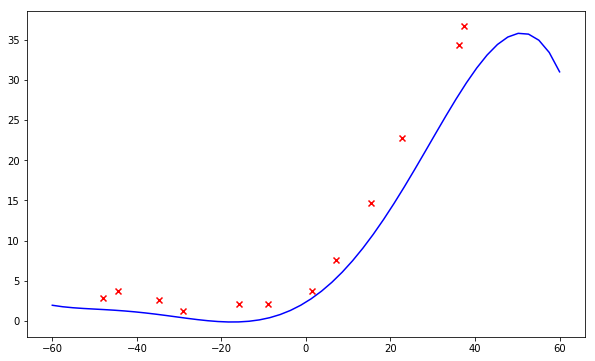

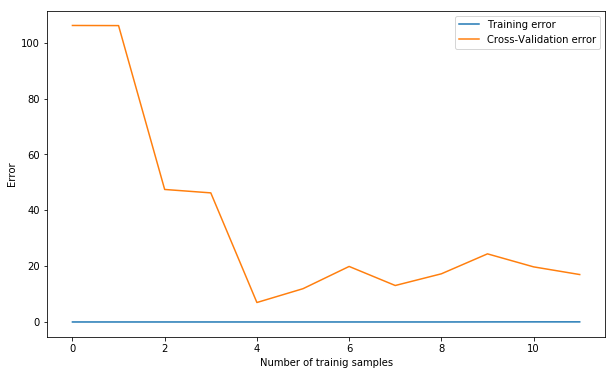

In [24]:
# Learning & Prediction

def poly_plot_prediction(theta, x, y, p):
    x_pred = np.linspace(-60, 60, 50)[:, None]
    y_pred = prediction(theta, feature_normalize(poly_features(x_pred, p))[0])
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.scatter(x, y, marker='x', c='r')
    ax.plot(x_pred, y_pred, c='b')

def poly_plot_learning_curves(xtrain, ytrain, xval, yval, p, regulator=0):
    m = len(ytrain)
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    initial_theta = np.ones(p + 1)
    num_samples = np.arange(m)
    xtrain_poly = feature_normalize(poly_features(xtrain, p))[0]
    xval_poly = feature_normalize(poly_features(xval, p))[0]
    for i in num_samples:
        theta = optimize_theta(initial_theta, xtrain_poly[:i+1, :], ytrain[:i+1], regulator)
        error_train[i] = cost_function(theta, xtrain_poly[:i+1, :], ytrain[:i+1])
        error_val[i] = cost_function(theta, xval_poly, yval)
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.plot(num_samples, error_train, label='Training error')
    ax.plot(num_samples, error_val, label='Cross-Validation error')
    ax.legend()
    ax.set_xlabel('Number of trainig samples')
    ax.set_ylabel('Error')

# regulator = 0
p = 5
X_poly = feature_normalize(poly_features(X, p))[0]
theta = np.ones(X_poly.shape[1] + 1)
theta = optimize_theta(theta, X_poly, y)
poly_plot_prediction(theta, X, y, p)
poly_plot_learning_curves(X, y, Xval, yval, 8)

The gap between the two learning curve suggests a high-variance problem. The regression fits the training data very well, but fits the cross-validation data sub-optimally. One way to combat this problem is to add regularization.

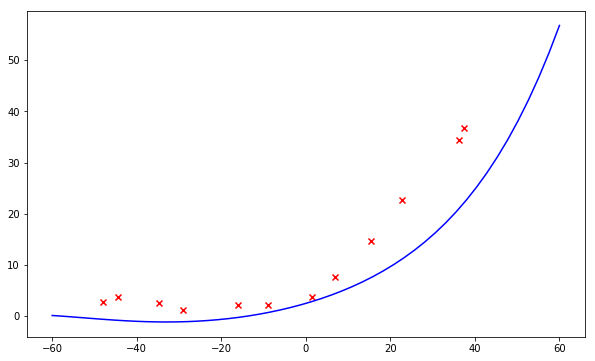

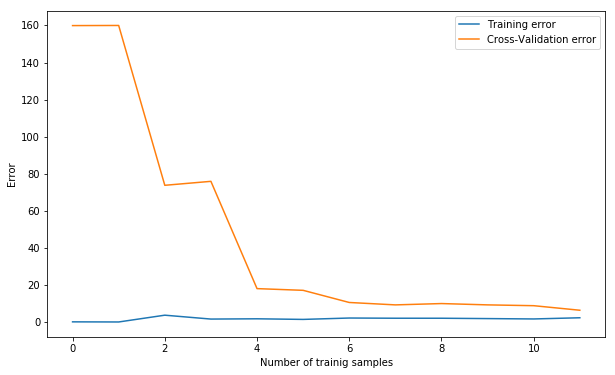

In [31]:
# regulator = 1
p = 5
X_poly = feature_normalize(poly_features(X, p))[0]
theta = np.ones(X_poly.shape[1] + 1)
theta = optimize_theta(theta, X_poly, y, 1)
poly_plot_prediction(theta, X, y, p)
poly_plot_learning_curves(X, y, Xval, yval, 8, 1)

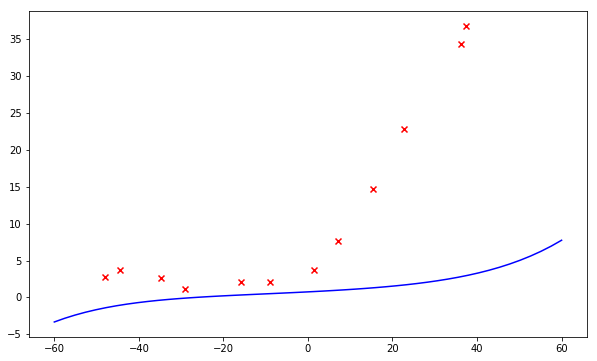

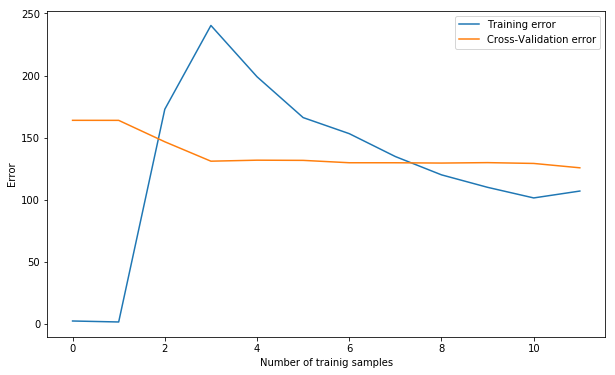

In [26]:
# regulator = 100
p = 5
X_poly = feature_normalize(poly_features(X, p))[0]
theta = np.ones(X_poly.shape[1] + 1)
theta = optimize_theta(theta, X_poly, y, 100)
poly_plot_prediction(theta, X, y, p)
poly_plot_learning_curves(X, y, Xval, yval, 8, 100)

Making the regulator too large leads to underfitting.

In [18]:
def poly_plot_regulator(xtrain, ytrain, xval, yval, p, reg_arr):
    m = len(reg_arr)
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    initial_theta = np.zeros(p + 1)
    xtrain_poly = feature_normalize(poly_features(xtrain, p))[0]
    xval_poly = feature_normalize(poly_features(xval, p))[0]
    for i in range(m):
        theta = optimize_theta(initial_theta, xtrain_poly, ytrain, reg_arr[i])
        error_train[i] = cost_function(theta, xtrain_poly, ytrain)
        error_val[i] = cost_function(theta, xval_poly, yval)
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.plot(reg_arr, error_train, label='Training error')
    ax.plot(reg_arr, error_val, label='Cross-Validation error')
    ax.legend()
    ax.set_xlabel('Regulator')
    ax.set_ylabel('Error')

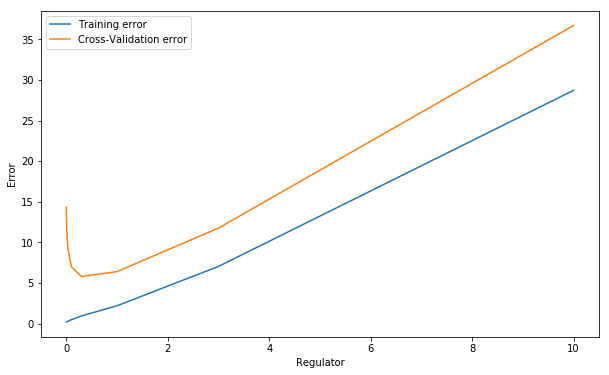

In [27]:
p = 5
reg_arr = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
poly_plot_regulator(X, y, Xval, yval, p, reg_arr)

From the graphs it appears that the optimum value of the regulator is around $0.5$, since both the training error and the cross-validation error are at their lowest there.

In [37]:
# Test set error
p = 5
X_poly = feature_normalize(poly_features(X, p))[0]
theta = np.ones(p + 1)
theta = optimize_theta(theta, X_poly, y, 0.5)
Xtest_poly = feature_normalize(poly_features(Xtest, p))[0]
test_error = cost_function(theta, Xtest_poly, ytest)
test_error

8.581348218658125